In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
import math
from collections import Counter, OrderedDict

In [4]:
datetime_parser = lambda dt: datetime.strptime(x, '%Y-%m-%d %H:%M')

In [5]:
covid_df = pd.read_csv( 'covid_19_india.csv', index_col='Sno')

In [6]:
state_testing_df = pd.read_csv( 'StatewiseTestingDetails.csv')
state_testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [7]:
census_df = pd.read_csv( 'population_india_census2011.csv')
census_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


### Data Cleaning

#### I. Covid 19 Data Frame

In [8]:
covid_df = pd.read_csv( 'covid_19_india.csv', index_col='Sno')

In [9]:
covid_df.dtypes

Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [10]:
covid_df

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
5,03/02/20,6:00 PM,Kerala,3,0,0,0,3
...,...,...,...,...,...,...,...,...
4457,24/07/20,8:00 AM,Telangana,-,-,39327,447,50826
4458,24/07/20,8:00 AM,Tripura,-,-,2072,10,3656
4459,24/07/20,8:00 AM,Uttarakhand,-,-,3399,60,5445


In [11]:
covid_df.Date = pd.to_datetime(covid_df.Date, format='%d/%m/%y')
covid_df = covid_df.rename(columns={"State/UnionTerritory": "State"})
covid_df.loc[:, 'Active'] = covid_df.loc[:, 'Confirmed'] - covid_df.loc[:, 'Deaths'] - covid_df.loc[:, 'Cured']
covid_df = covid_df[['Date', 'State', 'Cured', 'Deaths', 'Confirmed', 'Active']]
covid_df.loc[:, "Fatality Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100

In [12]:
report_date = '2020-07-23'
covid_df = covid_df[~(covid_df.State == 'Cases being reassigned to states')]
latest_df = covid_df[covid_df.Date == report_date]

In [13]:
latest_df

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
4392,2020-07-23,Andaman and Nicobar Islands,163,0,221,58,0.000000
4393,2020-07-23,Andhra Pradesh,32127,823,64713,31763,2.561708
4394,2020-07-23,Arunachal Pradesh,314,3,949,632,0.955414
4395,2020-07-23,Assam,18033,64,26772,8675,0.354905
4396,2020-07-23,Bihar,19646,217,30369,10506,1.104551
4397,2020-07-23,Chandigarh,526,13,793,254,2.471483
4398,2020-07-23,Chhattisgarh,4230,29,5968,1709,0.685579
4399,2020-07-23,Dadra and Nagar Haveli and Daman and Diu,474,2,733,257,0.421941
4400,2020-07-23,Delhi,107650,3719,126323,14954,3.454714


### Statewise Testing

In [14]:
state_testing_df.dtypes

Date             object
State            object
TotalSamples    float64
Negative         object
Positive        float64
dtype: object

In [15]:
state_testing_df.Date = pd.to_datetime(state_testing_df.Date, format='%Y-%m-%d')

In [16]:
state_testing_df = state_testing_df.set_index('Date')

In [17]:
state_testing_df.describe()

,TotalSamples,Positive
count,3.400000e+03,3386.000000
mean,1.766570e+05,10122.555818
std,2.876818e+05,29780.768372
min,5.800000e+01,0.000000
25%,1.042700e+04,130.000000
50%,4.826750e+04,1077.000000
75%,2.228228e+05,6640.750000
max,2.157869e+06,352760.000000


In [18]:
state_testing_df.isna().sum()

State              0
TotalSamples       0
Negative        1119
Positive          14
dtype: int64

In [19]:
state_testing_df[state_testing_df['Positive'].isna()]

,State,TotalSamples,Negative,Positive
Date,,,,
2020-07-23,Assam,723287.0,NaN,NaN
2020-04-01,Delhi,2621.0,NaN,NaN
2020-07-23,Gujarat,591561.0,NaN,NaN
2020-04-05,Maharashtra,16008.0,14837,NaN
2020-05-04,Sikkim,170.0,169,NaN
2020-07-15,Sikkim,13352.0,11355,NaN
2020-07-17,Uttar Pradesh,1379534.0,NaN,NaN
2020-07-21,Uttar Pradesh,1554116.0,NaN,NaN
2020-04-04,West Bengal,1042.0,NaN,NaN


In [20]:
state_testing_df['Negative'] = state_testing_df['TotalSamples'] - state_testing_df['Positive']

In [21]:
state_testing_df.isna().sum()

State            0
TotalSamples     0
Negative        14
Positive        14
dtype: int64

In [22]:
state_testing_df = state_testing_df[~(state_testing_df.Positive.isna())]

In [23]:
covid_temp = covid_df

In [24]:
covid_temp = covid_temp.set_index('Date')

In [25]:
covid_temp.head()

,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Date,,,,,,
2020-01-30,Kerala,0,0,1,1,NaN
2020-01-31,Kerala,0,0,1,1,NaN
2020-02-01,Kerala,0,0,2,2,NaN
2020-02-02,Kerala,0,0,3,3,NaN
2020-02-03,Kerala,0,0,3,3,NaN


In [26]:
merged_df = pd.merge(covid_temp, state_testing_df, how='inner', left_index=True, right_index=True, on='State')

In [27]:
state_testing_temp = state_testing_df
state_testing_temp = state_testing_temp.set_index(['State'], append=True)
covid_temp = covid_temp.set_index(['State'], append=True)

In [28]:
merged_df = pd.merge(covid_temp, state_testing_temp, left_index=True, right_index=True, how='left').fillna(0)

In [29]:
merged_df = merged_df.sort_index(level=0, ascending=False)

In [30]:
# covid_df.loc[:, "Positive Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100
merged_df.loc[merged_df.index.get_level_values(1) == 'Maharashtra']

,,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive
Date,State,,,,,,,,
2020-07-24,Maharashtra,194253,12854,347502,140395,6.617144,0.0,0.0,0.0
2020-07-23,Maharashtra,187769,12556,337607,137282,6.686940,1741992.0,1389232.0,352760.0
2020-07-22,Maharashtra,182217,12276,327031,132538,6.737022,1691546.0,1348610.0,342936.0
2020-07-21,Maharashtra,175029,12030,318695,131636,6.873147,1643981.0,1311150.0,332831.0
2020-07-20,Maharashtra,169569,11854,310455,129032,6.990665,1603802.0,1279592.0,324210.0
...,...,...,...,...,...,...,...,...,...
2020-03-13,Maharashtra,0,0,14,14,0.000000,0.0,0.0,0.0
2020-03-12,Maharashtra,0,0,11,11,0.000000,0.0,0.0,0.0
2020-03-11,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0


## Data Analysis

### Top 10 States with Max Fatalities

In [31]:
merged_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-07-24 West Bengal    31656    1255      51757   18846       3.964493   
           Uttarakhand     3399      60       5445    1986       1.765225   
           Uttar Pradesh  35803    1289      58104   21012       3.600257   
           Tripura         2072      10       3656    1574       0.482625   
           Telangana      39327     447      50826   11052       1.136624   

                          TotalSamples  Negative  Positive  
Date       State                                            
2020-07-24 West Bengal             0.0       0.0       0.0  
           Uttarakhand             0.0       0.0       0.0  
           Uttar Pradesh           0.0       0.0       0.0  
           Tripura                 0.0       0.0       0.0  
           Telangana               0.0       0.0       0.0

In [32]:
latest_df = latest_df.sort_values(by='Deaths', ascending=False)
top_10_states_with_highest_fatalities = latest_df[:10]

### Top 10 States with Highest Fatality Rates

In [33]:
latest_df = latest_df.sort_values(by='Fatality Rate', ascending=False)

In [34]:
top_10_states_with_highest_fatality_rate = latest_df[:10]

In [35]:
top_10_states_with_highest_fatality_rate.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
4411,2020-07-23,Maharashtra,187769,12556,337607,137282,6.686940
4402,2020-07-23,Gujarat,37260,2224,51399,11915,5.968867
4407,2020-07-23,Karnataka,27239,1519,75833,47075,5.576563
4413,2020-07-23,Meghalaya,77,4,514,433,5.194805
4410,2020-07-23,Madhya Pradesh,16836,770,24842,7236,4.573533


### Day wise Covid-19 statistics for each State

In [36]:
merged_df.head(20)

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                              
2020-07-24 West Bengal      31656    1255      51757   18846       3.964493   
           Uttarakhand       3399      60       5445    1986       1.765225   
           Uttar Pradesh    35803    1289      58104   21012       3.600257   
           Tripura           2072      10       3656    1574       0.482625   
           Telangana        39327     447      50826   11052       1.136624   
           Tamil Nadu      136793    3232     192964   52939       2.362694   
           Sikkim             122       0        460     338       0.000000   
           Rajasthan        23815     594      33220    8811       2.494226   
           Punjab            7741     277      11739    3721       3.578349   
           Puducherry        1400      34       2420     986       2.428571   
           Odisha           14393     114      21099    6592       0.792052   
           Nagaland           530       0       1174     644       0.000000   
           Mizoram            183       0        332     149       0.000000   
           Meghalaya           78       4        534     452       5.128205   
           Manipur           1466       0       2115     649       0.000000   
           Maharashtra     194253   12854     347502  140395       6.617144   
           Madhya Pradesh   17359     780      25474    7335       4.493346   
           Ladakh            1025       2       1210     183       0.195122   
           Kerala            6594      50      16110    9466       0.758265   
           Karnataka        29310    1616      80863   49937       5.513477   

                           TotalSamples  Negative  Positive  
Date       State                                             
2020-07-24 West Bengal              0.0       0.0       0.0  
           Uttarakhand              0.0       0.0       0.0  
           Uttar Pradesh            0.0       0.0       0.0  
           Tripura                  0.0       0.0       0.0  
           Telangana                0.0       0.0       0.0  
           Tamil Nadu               0.0       0.0       0.0  
           Sikkim                   0.0       0.0       0.0  
           Rajasthan                0.0       0.0       0.0  
           Punjab                   0.0       0.0       0.0  
           Puducherry               0.0       0.0       0.0  
           Odisha                   0.0       0.0       0.0  
           Nagaland                 0.0       0.0       0.0  
           Mizoram                  0.0       0.0       0.0  
           Meghalaya                0.0       0.0       0.0  
           Manipur                  0.0       0.0       0.0  
           Maharashtra              0.0       0.0       0.0  
           Madhya Pradesh           0.0       0.0       0.0  
           Ladakh                   0.0       0.0       0.0  
           Kerala                   0.0       0.0       0.0  
           Karnataka                0.0       0.0       0.0

### State Level Aggregated DF with Census DF and Covid Counts

In [37]:
census_df = census_df.rename(columns={"State / Union Territory": "State"}).set_index('State').drop(columns='Sno')

In [38]:
aggregated_df = pd.merge(merged_df, census_df, left_index=True, right_index=True)

In [39]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  
Date       State                        
2020-07-24 West Bengal             953  
           Uttarakhand             963  
           Uttar Pradesh           912  
           Tripura                 960  
           Tamil Nadu              996

In [40]:
hosp_df = pd.read_csv('HospitalBedsIndia.csv')
hosp_df_min = hosp_df[['State/UT', 'NumPublicBeds_HMIS', 'NumRuralBeds_NHP18', 'NumUrbanBeds_NHP18']]

In [41]:
hosp_df_min = hosp_df_min.rename(columns={"State/UT":"State", "NumPublicBeds_HMIS": "Public Beds", 
                            "NumRuralBeds_NHP18": "Rural Beds", "NumUrbanBeds_NHP18": "Urban Beds"}).set_index('State')

In [42]:
aggregated_df = pd.merge(aggregated_df, hosp_df_min, left_index=True, right_index=True)

In [43]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-07-24 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [44]:
fatality_df = covid_df[covid_df['Fatality Rate'].notna()]
fatality_df = fatality_df[~(fatality_df['Fatality Rate'] == np.inf)]
fatality_df.dtypes

Date             datetime64[ns]
State                    object
Cured                     int64
Deaths                    int64
Confirmed                 int64
Active                    int64
Fatality Rate           float64
dtype: object

In [45]:
fatality_df = fatality_df.set_index('Date')
fatality_rate_maha = fatality_df[fatality_df['State'] == 'Maharashtra']

In [46]:
states = ['Maharashtra', 'Delhi', 'Gujarat', 'Kerela', 'Madhya Pradesh', "Uttar Pradesh"]

In [47]:
df_temp = fatality_df[fatality_df.State.isin(states)]

In [48]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-07-24 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [49]:
aggregated_df.loc[:, 'Total Beds'] = aggregated_df['Public Beds'] + aggregated_df['Rural Beds'] + aggregated_df['Urban Beds']

C:\Users\govin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [50]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Confirmed > 1000]

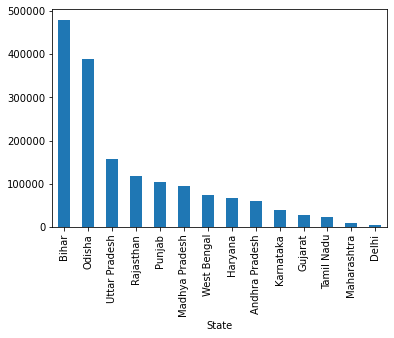

In [51]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date]
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Deaths > 100]

ser_pop_deaths_ratio = (latest_df.Population / latest_df.Deaths).sort_values(ascending=False)
ser_pop_deaths_ratio.plot(kind='bar')


In [52]:
ser_pop_deaths_ratio

State
Bihar             479720.976959
Odisha            388650.166667
Uttar Pradesh     158204.545527
Rajasthan         117578.794168
Punjab            103135.085502
Madhya Pradesh     94320.531169
West Bengal        74755.212940
Haryana            68149.091398
Andhra Pradesh     60239.493317
Karnataka          40220.735352
Gujarat            27176.120504
Tamil Nadu         22947.528626
Maharashtra         8949.851306
Delhi               4514.100834
dtype: float64

### Beds to Active Patients Ratio

In [53]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == report_date, :].reset_index()
latest_df.loc[:, 'Beds/Active'] = latest_df['Total Beds'] / latest_df['Active']
df_least_beds_to_patients_ratio = latest_df.sort_values(by='Beds/Active', ascending=True).head(10)

### Finding:

- As per above statistics, if we include only covid patients, there are only 2.5 beds available for 1 covid-19 patient in Maharashtra, which is alarming, given covid-19 is yet to peak.


- Also, there are only 2 beds available for each covid-19 patient in Delhi.

### Mortality rate per 1000000

In [54]:
latest_df.loc[:, 'Mortality/1000000'] = (latest_df['Deaths'] / latest_df['Population']) * 1000000
latest_df['Population_Density_square_km'] = latest_df['Density'].str.split('/').str[0]
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,...,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-07-23,West Bengal,29650,1221,49321,18450,4.118044,758027.0,706270.0,51757.0,...,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,7.031382,13.376994,"1,029"
1,2020-07-23,Uttarakhand,3349,57,5300,1894,1.702001,132840.0,127395.0,5445.0,...,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,8.010560,5.651234,189
2,2020-07-23,Uttar Pradesh,33500,1263,55588,20825,3.770149,1654651.0,1596547.0,58104.0,...,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,6.461945,6.320931,828
3,2020-07-23,Tripura,2032,9,3449,1408,0.442913,127742.0,124065.0,3677.0,...,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,6.613636,2.449702,350
4,2020-07-23,Tamil Nadu,131583,3144,186492,51765,2.389366,2157869.0,1964905.0,192964.0,...,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,2.900570,43.577677,555


In [55]:
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].str.replace(',', '')
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].astype(np.int)

In [56]:
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,...,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
0,2020-07-23,West Bengal,29650,1221,49321,18450,4.118044,758027.0,706270.0,51757.0,...,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953,51163,19684,58882,129729,7.031382,13.376994,1029
1,2020-07-23,Uttarakhand,3349,57,5300,1894,1.702001,132840.0,127395.0,5445.0,...,"53,483 km2 (20,650 sq mi)",189/km2 (490/sq mi),963,6660,3284,5228,15172,8.010560,5.651234,189
2,2020-07-23,Uttar Pradesh,33500,1263,55588,20825,3.770149,1654651.0,1596547.0,58104.0,...,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912,58310,39104,37156,134570,6.461945,6.320931,828
3,2020-07-23,Tripura,2032,9,3449,1408,0.442913,127742.0,124065.0,3677.0,...,"10,486 km2 (4,049 sq mi)",350/km2 (910/sq mi),960,4895,1140,3277,9312,6.613636,2.449702,350
4,2020-07-23,Tamil Nadu,131583,3144,186492,51765,2.389366,2157869.0,1964905.0,192964.0,...,"130,058 km2 (50,216 sq mi)","555/km2 (1,440/sq mi)",996,72616,40179,37353,150148,2.900570,43.577677,555


In [57]:
covid_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
1,2020-01-30,Kerala,0,0,1,1,NaN
2,2020-01-31,Kerala,0,0,1,1,NaN
3,2020-02-01,Kerala,0,0,2,2,NaN
4,2020-02-02,Kerala,0,0,3,3,NaN
5,2020-02-03,Kerala,0,0,3,3,NaN


### Visual Analysis of most affected states

In [58]:
aggregated_df.index.get_level_values(1).unique()

Index(['West Bengal', 'Uttarakhand', 'Uttar Pradesh', 'Tripura', 'Tamil Nadu',
       'Sikkim', 'Rajasthan', 'Punjab', 'Puducherry', 'Odisha', 'Nagaland',
       'Mizoram', 'Meghalaya', 'Manipur', 'Maharashtra', 'Madhya Pradesh',
       'Kerala', 'Karnataka', 'Jharkhand', 'Himachal Pradesh', 'Haryana',
       'Gujarat', 'Goa', 'Delhi', 'Chhattisgarh', 'Chandigarh', 'Bihar',
       'Assam', 'Arunachal Pradesh', 'Andhra Pradesh'],
      dtype='object', name='State')

In [59]:
temp_df = aggregated_df.reset_index()
top_states_df = temp_df[temp_df['State'].isin(['Maharashtra', 'Gujarat', 'Tamil Nadu', 'Delhi', 'Madhya Pradesh'])].set_index(['Date', 'State']).sort_index(axis =0, ascending=True)[['Cured', 'Deaths', 'Confirmed', 'Active', 'Positive', 'TotalSamples', 'Negative']]

In [60]:
top_states_df_daily_counts = top_states_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff().fillna(top_states_df)
top_states_df_daily_counts = top_states_df_daily_counts.query('TotalSamples > 0')
top_states_df_daily_counts = top_states_df_daily_counts.query('Confirmed > 0')

In [61]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index('Date')

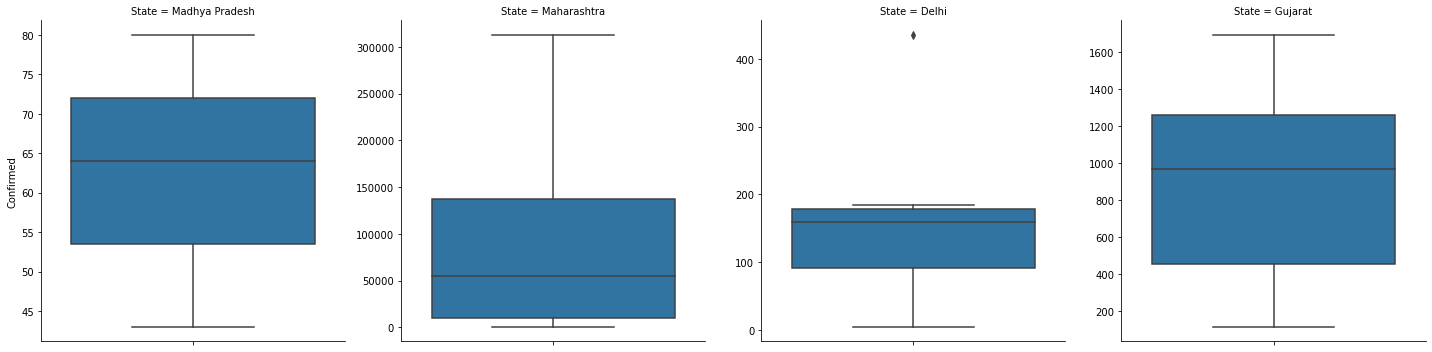

In [62]:
sns.catplot(y='Confirmed', kind='box' ,data=top_states_df_daily_counts, col='State', sharey=False)

In [63]:
top_states_df_daily_counts = top_states_df_daily_counts.reset_index().set_index(['Date', 'State'])

In [64]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Deaths > 0]
temp = temp.reset_index().set_index(['Date'])

In [65]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Confirmed > 0]
temp = temp.reset_index().set_index('Date')

In [66]:
temp = top_states_df_daily_counts[top_states_df_daily_counts.Active > 0]
temp = temp.reset_index().set_index('Date')

#### Plot to show correlation between Confirmed Cases and Deaths

In [67]:
temp = temp.set_index('State', append=True)

In [68]:
temp = temp[(temp.values > 0).all(1)]
temp = temp.reset_index().set_index('Date')

In [69]:
sorted_agg_df = aggregated_df.sort_index(level=0, ascending=True)

In [70]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-24 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-24 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

### Maharashtra Covid Analysis 

In [71]:
maha_df = aggregated_df.query('State == "Maharashtra"').reset_index().set_index('Date').sort_index(axis=0, ascending=True)
maha_df

,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds
Date,,,,,,,,,,,,,,,,,,,
2020-03-09,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-10,Maharashtra,0,0,5,5,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-11,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-12,Maharashtra,0,0,11,11,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-13,Maharashtra,0,0,14,14,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,Maharashtra,169569,11854,310455,129032,6.990665,1603802.0,1279592.0,324210.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-21,Maharashtra,175029,12030,318695,131636,6.873147,1643981.0,1311150.0,332831.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-22,Maharashtra,182217,12276,327031,132538,6.737022,1691546.0,1348610.0,342936.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444


In [72]:
maha_df = aggregated_df.query('State == "Maharashtra"').reset_index().set_index('Date').sort_index(axis=0, ascending=True)

In [73]:
maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].tail(10)

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-07-15,1413185.0,149007,267665,10695,107963,1132434.0,280751.0
2020-07-16,1450129.0,152613,275640,10928,112099,1161433.0,288696.0
2020-07-17,1487738.0,158140,284281,11194,114947,1190958.0,296780.0
2020-07-18,1526037.0,160357,292589,11452,120780,1220496.0,305541.0
2020-07-19,1568229.0,165663,300937,11596,123678,1252842.0,315387.0
2020-07-20,1603802.0,169569,310455,11854,129032,1279592.0,324210.0
2020-07-21,1643981.0,175029,318695,12030,131636,1311150.0,332831.0
2020-07-22,1691546.0,182217,327031,12276,132538,1348610.0,342936.0
2020-07-23,1741992.0,187769,337607,12556,137282,1389232.0,352760.0


In [74]:
maha_df_daily_counts = maha_df[['TotalSamples', 'Cured', 'Confirmed', 'Deaths', 'Active', 'Negative', 'Positive']].diff()

In [75]:
df_t = maha_df_daily_counts.pct_change().dropna()

In [76]:
df_t = df_t[(df_t.values != np.inf).all(1)]

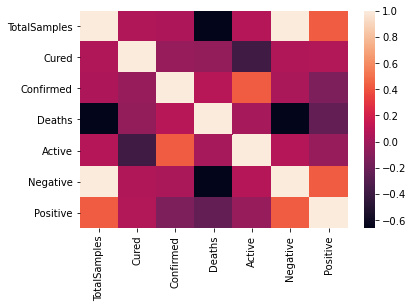

In [77]:
sns.heatmap(df_t.corr())

C:\Users\govin\anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


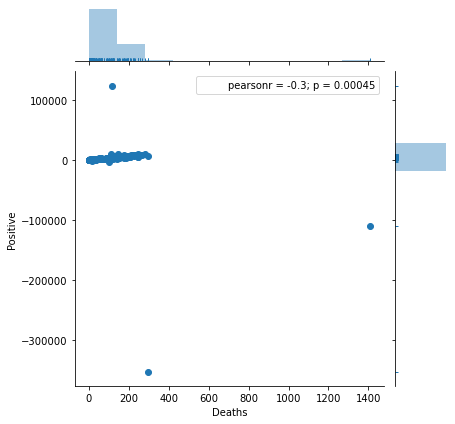

In [78]:
sns.jointplot(x='Deaths', y='Positive', data=maha_df_daily_counts, kind='scatter', marginal_kws=dict(bins=10, rug=True), stat_func=scipy.stats.pearsonr)

In [79]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples > 0')

In [80]:
maha_df_daily_counts.head()

,TotalSamples,Cured,Confirmed,Deaths,Active,Negative,Positive
Date,,,,,,,
2020-04-06,17563.0,14.0,258.0,21.0,223.0,16695.0,868.0
2020-04-07,3314.0,0.0,120.0,3.0,117.0,3164.0,150.0
2020-04-09,20877.0,38.0,117.0,8.0,71.0,20009.0,868.0
2020-04-10,9123.0,8.0,229.0,25.0,196.0,8856.0,267.0
2020-04-11,1841.0,63.0,210.0,13.0,134.0,1215.0,626.0


In [81]:
maha_df_daily_counts = maha_df_daily_counts.query('TotalSamples < 500000')

### % Positive Cases each Day 

In [82]:
positive_cases_df = aggregated_df[aggregated_df.TotalSamples > 0]

In [83]:
aggregated_df.shape

(3774, 18)

In [84]:
positive_cases_df.shape

(2963, 18)

In [85]:
print(f"There are {aggregated_df.shape[0] - positive_cases_df.shape[0]} records where Testing Data is not available.")

There are 811 records where Testing Data is not available.


In [86]:
positive_cases_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-23 West Bengal     29650    1221      49321   18450       4.118044   
           Uttarakhand      3349      57       5300    1894       1.702001   
           Uttar Pradesh   33500    1263      55588   20825       3.770149   
           Tripura          2032       9       3449    1408       0.442913   
           Tamil Nadu     131583    3144     186492   51765       2.389366   

                          TotalSamples   Negative  Positive  Population  \
Date       State                                                          
2020-07-23 West Bengal        758027.0   706270.0   51757.0    91276115   
           Uttarakhand        132840.0   127395.0    5445.0    10086292   
           Uttar Pradesh     1654651.0  1596547.0   58104.0   199812341   
           Tripura            127742.0   124065.0    3677.0     3673917   
           Tamil Nadu        2157869.0  1964905.0  192964.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-23 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-23 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-23 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-23 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

In [87]:
positive_cases_df['%Positive'] = (positive_cases_df['Positive'] / positive_cases_df['TotalSamples']) * 100 

<ipython-input-87-95fcc5db5b0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cases_df['%Positive'] = (positive_cases_df['Positive'] / positive_cases_df['TotalSamples']) * 100


In [88]:
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']

In [89]:
top_states_positive_cases_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(main_states)]

In [90]:
maharashtra_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Maharashtra'])]
delhi_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Delhi'])]
tamil_nadu_positive_df = positive_cases_df.loc[positive_cases_df.index.get_level_values(1).isin(['Tamil Nadu'])]

In [91]:
top_states_positive_cases_df = top_states_positive_cases_df.reset_index(level=1)

In [92]:
start_lockdown1 = '2020-03-25'
end_lockdown1 = '2020-04-14'
start_lockdown2 = '2020-04-15'
end_lockdown2 = '2020-05-03'
start_lockdown3 = '2020-05-04'
end_lockdown3 = '2020-05-17'
start_lockdown4 = '2020-05-18'
end_lockdown4 = '2020-05-31'
start_lockdown5 = '2020-06-01'
end_lockdown5 = '2020-06-30'
start_lockdown6 = '2020-07-01'
end_lockdown6 = report_date

### Avg Number of Tests Conducted Per Lockdown

In [93]:
start_lockdown_minus_1 = (datetime.datetime.strptime(start_lockdown1, '%Y-%m-%d') - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
start_lockdown_minus_1

'2020-03-24'

In [94]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-07-24 West Bengal     31656    1255      51757   18846       3.964493   
           Uttarakhand      3399      60       5445    1986       1.765225   
           Uttar Pradesh   35803    1289      58104   21012       3.600257   
           Tripura          2072      10       3656    1574       0.482625   
           Tamil Nadu     136793    3232     192964   52939       2.362694   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-07-24 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-07-24 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-07-24 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  \
Date       State                                                              
2020-07-24 West Bengal             953        51163       19684       58882   
           Uttarakhand             963         6660        3284        5228   
           Uttar Pradesh           912        58310       39104       37156   
           Tripura                 960         4895        1140        3277   
           Tamil Nadu              996        72616       40179       37353   

                          Total Beds  
Date       State                      
2020-07-24 West Bengal        129729  
           Uttarakhand         15172  
           Uttar Pradesh      134570  
           Tripura              9312  
           Tamil Nadu         150148

In [95]:
df_samples = aggregated_df.loc[aggregated_df.index.get_level_values(0).isin([start_lockdown_minus_1, end_lockdown1, end_lockdown2, 
                                                                end_lockdown3, end_lockdown4,
                                                               end_lockdown5])][['TotalSamples', 'Confirmed', 'Active', 'Deaths', 'Cured', 'Positive']]

In [96]:
df_samples = df_samples.reset_index(level=1)

In [97]:
df_samples['%Positive'] = df_samples['Positive'] / df_samples['TotalSamples'] * 100

In [98]:
df_samples.head()

,State,TotalSamples,Confirmed,Active,Deaths,Cured,Positive,%Positive
Date,,,,,,,,
2020-06-30,West Bengal,488038.0,17907,5535,653,11719,18559.0,3.802778
2020-06-30,Uttarakhand,69024.0,2831,681,39,2111,2881.0,4.173911
2020-06-30,Uttar Pradesh,727793.0,22828,6650,672,15506,23492.0,3.227841
2020-06-30,Tripura,64478.0,1380,294,1,1085,1393.0,2.160427
2020-06-30,Tamil Nadu,1170683.0,86224,37334,1141,47749,90167.0,7.702085


In [99]:
unique_states = set(df_samples['State'])

In [100]:
df_samples[df_samples.State == 'Delhi']

,State,TotalSamples,Confirmed,Active,Deaths,Cured,Positive,%Positive
Date,,,,,,,,
2020-06-30,Delhi,531752.0,85161,26246,2680,56235,87360.0,16.428711
2020-05-31,Delhi,212784.0,18549,10058,416,8075,19844.0,9.325889
2020-05-17,Delhi,135791.0,9333,5278,129,3926,9755.0,7.183834
2020-05-03,Delhi,60246.0,4122,2802,64,1256,4549.0,7.550709
2020-04-14,Delhi,16282.0,1510,1452,28,30,1561.0,9.587274
2020-03-24,Delhi,0.0,30,23,1,6,0.0,NaN


In [101]:
d2 = df_samples[df_samples.State == 'Delhi'].set_index('State', append=True).diff().dropna()[['TotalSamples']].apply(np.abs)
d3 = df_samples[df_samples.State == 'Maharashtra'].set_index('State', append=True).diff().dropna()[['TotalSamples']].apply(np.abs)

In [102]:
pd.concat([d2, d3])

,,TotalSamples
Date,State,
2020-05-31,Delhi,318968.0
2020-05-17,Delhi,76993.0
2020-05-03,Delhi,75545.0
2020-04-14,Delhi,43964.0
2020-05-31,Maharashtra,506984.0
2020-05-17,Maharashtra,189137.0
2020-05-03,Maharashtra,114286.0
2020-04-14,Maharashtra,118683.0


In [103]:
df_samples_final = pd.DataFrame()

for state in main_states:
    d = df_samples[df_samples.State == state].set_index('State', append=True).diff().dropna()[['TotalSamples', 'Confirmed', 'Active', 'Deaths', 'Cured', '%Positive']].apply(np.abs)
    df_samples_final = pd.concat([df_samples_final, d])


In [104]:
dft = df_samples_final.reset_index(level=1)
dft.index = dft.index.astype(str)

In [105]:
date_to_lockdown_number_map = {"2020-05-31": "Lockdown5", "2020-05-17": "Lockdown4", "2020-05-03": "Lockdown3", "2020-04-14": "Lockdown2", "2020-03-24": "Lockdown1"}

In [106]:
list_lockdown_number = list(dft.index.map(lambda val: date_to_lockdown_number_map[str(val)]))

In [107]:
df_samples_final.loc[:, 'Lockdown_Number'] = list_lockdown_number

In [108]:
df_samples_final = df_samples_final.reset_index(level=1)
df_samples_final = df_samples_final.sort_values(by='Lockdown_Number')

### The two plots below explain the reason behind recent surge in number of cases  

In [109]:
df_tmp = top_states_positive_cases_df.reset_index()

### The plots below illustrates how % positive cases are surging with increase Tests being conducted.

### Analyzing Each Lockdown 

In [110]:
lockdown1_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown1) & (aggregated_df.index.get_level_values(0) <= end_lockdown1)]
lockdown2_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown2) & (aggregated_df.index.get_level_values(0) <= end_lockdown2)]
lockdown3_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown3) & (aggregated_df.index.get_level_values(0) <= end_lockdown3)]
lockdown4_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown4) & (aggregated_df.index.get_level_values(0) <= end_lockdown4)]
lockdown5_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown5) & (aggregated_df.index.get_level_values(0) <= end_lockdown5)]
lockdown6_df = aggregated_df.loc[(aggregated_df.index.get_level_values(0) >= start_lockdown6) & (aggregated_df.index.get_level_values(0) <= end_lockdown6)]

In [111]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['Confirmed']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-04-14,2020-03-25,pct_increase1
2,Madhya Pradesh,730.0,14.0,5114.285714
3,Delhi,1510.0,31.0,4770.967742
7,West Bengal,190.0,9.0,2011.111111
8,Maharashtra,2337.0,128.0,1725.781250
11,Gujarat,617.0,38.0,1523.684211


In [112]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['Confirmed']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-03,2020-04-15,pct_increase2
0,Gujarat,5055.0,695.0,627.338129
2,Maharashtra,12296.0,2687.0,357.610718
4,West Bengal,922.0,213.0,332.863850
9,Madhya Pradesh,2846.0,987.0,188.348531
12,Delhi,4122.0,1561.0,164.061499


In [113]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['Confirmed']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-17,2020-05-04,pct_increase3
4,West Bengal,2576,963,167.497404
6,Maharashtra,30706,12974,136.673347
9,Delhi,9333,4549,105.165971
11,Gujarat,10988,5428,102.431835
18,Madhya Pradesh,4789,2942,62.780421


In [114]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['Confirmed']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-05-31,2020-05-18,pct_increase4
15,Maharashtra,65168.0,33053.0,97.162134
16,West Bengal,5130.0,2677.0,91.632424
18,Delhi,18549.0,10054.0,84.493734
22,Madhya Pradesh,7891.0,4977.0,58.549327
25,Gujarat,16343.0,11379.0,43.624220


In [115]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [116]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['Confirmed']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-06-30,2020-06-01,pct_increase5
12,Delhi,85161,19844,329.152389
18,West Bengal,17907,5501,225.522632
23,Maharashtra,169883,67655,151.101914
26,Gujarat,31938,16779,90.345074
28,Madhya Pradesh,13370,8089,65.286191


In [117]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['Confirmed']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat'])]

Date,State,2020-07-23,2020-07-01,pct_increase6
11,West Bengal,49321,18559,165.752465
21,Maharashtra,337607,174761,93.182117
23,Madhya Pradesh,24842,13593,82.755830
28,Gujarat,51399,32557,57.873883
29,Delhi,126323,87360,44.600504


In [118]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [119]:
from functools import reduce

In [120]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [121]:
columns = ["State", "%Change", "Lockdown_Number"]
list_of_values = []

In [122]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,Tamil Nadu,1173.0,18.0,6416.666667,2757.0,1204.0,128.986711,10585,3023,250.148859,21184.0,11224.0,88.738418,86224,22333,286.083374,186492,90167,106.829550
2,Madhya Pradesh,730.0,14.0,5114.285714,2846.0,987.0,188.348531,4789,2942,62.780421,7891.0,4977.0,58.549327,13370,8089,65.286191,24842,13593,82.755830
3,Delhi,1510.0,31.0,4770.967742,4122.0,1561.0,164.061499,9333,4549,105.165971,18549.0,10054.0,84.493734,85161,19844,329.152389,126323,87360,44.600504
7,West Bengal,190.0,9.0,2011.111111,922.0,213.0,332.863850,2576,963,167.497404,5130.0,2677.0,91.632424,17907,5501,225.522632,49321,18559,165.752465
8,Maharashtra,2337.0,128.0,1725.781250,12296.0,2687.0,357.610718,30706,12974,136.673347,65168.0,33053.0,97.162134,169883,67655,151.101914,337607,174761,93.182117
9,Uttar Pradesh,657.0,37.0,1675.675676,2626.0,735.0,257.278912,4258,2742,55.288111,7445.0,4259.0,74.806293,22828,7823,191.806212,55588,23492,136.625234
10,Bihar,66.0,4.0,1550.000000,482.0,70.0,588.571429,1179,517,128.046422,3636.0,1262.0,188.114105,9640,3815,152.686763,30369,10043,202.389724


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [123]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [124]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [125]:
df_pct_inc = df_final[df_final.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Gujarat', 'Tamil Nadu'])][['State', 'pct_increase1', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5']]

In [126]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase1'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5']) / 5

### Recovery Rate for State per lockdown

In [127]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['Cured']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1
0,West Bengal,36.0,0.0,inf
2,Bihar,26.0,0.0,inf
8,Madhya Pradesh,51.0,0.0,inf
12,Maharashtra,229.0,1.0,2.280000e+04
13,Tamil Nadu,58.0,1.0,5.700000e+03
18,Delhi,30.0,6.0,4.000000e+02
19,Uttar Pradesh,49.0,11.0,3.454545e+02


In [128]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['Cured']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(main_states)]

Date,State,2020-05-03,2020-04-15,pct_increase2
4,Delhi,1256.0,30.0,4086.666667
6,Tamil Nadu,1341.0,81.0,1555.555556
8,Uttar Pradesh,698.0,51.0,1268.627451
9,Madhya Pradesh,798.0,64.0,1146.875000
11,Maharashtra,2000.0,259.0,672.200772
16,West Bengal,151.0,37.0,308.108108
17,Bihar,117.0,29.0,303.448276


In [129]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['Cured']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(main_states)]

Date,State,2020-05-17,2020-05-04,pct_increase3
4,West Bengal,872,151,477.483444
7,Bihar,453,125,262.400000
8,Maharashtra,7088,2115,235.130024
10,Uttar Pradesh,2441,758,222.031662
11,Madhya Pradesh,2315,798,190.100251
12,Delhi,3926,1362,188.252570
15,Tamil Nadu,3538,1379,156.562727


In [130]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['Cured']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(main_states)]

Date,State,2020-05-31,2020-05-18,pct_increase4
5,Maharashtra,28081.0,7688.0,265.257544
6,Bihar,1618.0,475.0,240.631579
7,Tamil Nadu,12000.0,4172.0,187.631831
10,West Bengal,1970.0,959.0,105.422315
16,Madhya Pradesh,4444.0,2403.0,84.935497
17,Uttar Pradesh,4410.0,2441.0,80.663662
18,Delhi,8075.0,4485.0,80.044593


In [131]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [132]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['Cured']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(main_states)]

Date,State,2020-06-30,2020-06-01,pct_increase5
12,Delhi,56235,8478,563.305025
15,West Bengal,11719,2157,443.300881
18,Bihar,7390,1710,332.163743
19,Tamil Nadu,47749,12757,274.296465
22,Uttar Pradesh,15506,4709,229.284349
23,Maharashtra,88960,29329,203.317536
27,Madhya Pradesh,10199,4842,110.636101


In [133]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['Cured']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(main_states)]

Date,State,2020-07-23,2020-07-01,pct_increase6
9,Tamil Nadu,131583,50074,162.777090
11,Bihar,19646,7687,155.574346
12,West Bengal,29650,12130,144.435284
15,Uttar Pradesh,33500,16084,108.281522
16,Maharashtra,187769,90911,106.541563
21,Delhi,107650,58348,84.496469
24,Madhya Pradesh,16836,10395,61.962482


In [134]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [135]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [136]:
columns = ["State", "%Change", "Lockdown_Number"]
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']
list_of_values = []

In [137]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,West Bengal,36.0,0.0,inf,151.0,37.0,308.108108,872,151,477.483444,1970.0,959.0,105.422315,11719,2157,443.300881,29650,12130,144.435284
2,Bihar,26.0,0.0,inf,117.0,29.0,303.448276,453,125,262.400000,1618.0,475.0,240.631579,7390,1710,332.163743,19646,7687,155.574346
8,Madhya Pradesh,51.0,0.0,inf,798.0,64.0,1146.875000,2315,798,190.100251,4444.0,2403.0,84.935497,10199,4842,110.636101,16836,10395,61.962482
12,Maharashtra,229.0,1.0,2.280000e+04,2000.0,259.0,672.200772,7088,2115,235.130024,28081.0,7688.0,265.257544,88960,29329,203.317536,187769,90911,106.541563
13,Tamil Nadu,58.0,1.0,5.700000e+03,1341.0,81.0,1555.555556,3538,1379,156.562727,12000.0,4172.0,187.631831,47749,12757,274.296465,131583,50074,162.777090
18,Delhi,30.0,6.0,4.000000e+02,1256.0,30.0,4086.666667,3926,1362,188.252570,8075.0,4485.0,80.044593,56235,8478,563.305025,107650,58348,84.496469
19,Uttar Pradesh,49.0,11.0,3.454545e+02,698.0,51.0,1268.627451,2441,758,222.031662,4410.0,2441.0,80.663662,15506,4709,229.284349,33500,16084,108.281522


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [138]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [139]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [140]:
df_lockdown_analysis = df_lockdown_analysis[df_lockdown_analysis['%Change'] != np.inf]

In [141]:
d_recovered = df_lockdown_analysis.sort_values(by='Lockdown_Number')

In [142]:
d_recovered = d_recovered[~(d_recovered.Lockdown_Number.isin(['Lockdown1']))]

#### Percentage Change in Recovered Cases for Main States per lockdown 

### Testing Rate per Lockdown

In [143]:
df1 = lockdown1_df.loc[lockdown1_df.index.get_level_values(0).isin([start_lockdown1, end_lockdown1])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df1 = df1.unstack(0)[['TotalSamples']].dropna()
df1.columns = df1.columns.droplevel(0)
df1.columns= df1.columns.astype(str)
df1['pct_increase1'] = (df1[end_lockdown1] - df1[start_lockdown1]) / df1[start_lockdown1] * 100
df1 = df1.sort_values(by='pct_increase1', ascending=False)
df_temp1 = df1.reset_index()
df_temp1[df_temp1.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1
0,West Bengal,3081.0,0.0,inf
2,Bihar,7727.0,0.0,inf
5,Delhi,16282.0,0.0,inf
10,Madhya Pradesh,8105.0,0.0,inf
12,Maharashtra,41071.0,0.0,inf
18,Tamil Nadu,19255.0,0.0,inf
19,Uttar Pradesh,15914.0,0.0,inf


In [144]:
df2 = lockdown2_df.loc[lockdown2_df.index.get_level_values(0).isin([start_lockdown2, end_lockdown2])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df2 = df2.unstack(0)[['TotalSamples']].dropna()
df2.columns = df2.columns.droplevel(0)
df2.columns= df2.columns.astype(str)
df2['pct_increase2'] = (df2[end_lockdown2] - df2[start_lockdown2]) / df2[start_lockdown2] * 100
df2 = df2.sort_values(by='pct_increase2', ascending=False)
df_temp2 = df2.reset_index()
df_temp2[df_temp2.State.isin(main_states)]

Date,State,2020-05-03,2020-04-15,pct_increase2
6,Tamil Nadu,150107.0,21994.0,582.490679
7,West Bengal,22915.0,3470.0,560.374640
9,Madhya Pradesh,49186.0,9596.0,412.567737
13,Uttar Pradesh,95841.0,19506.0,391.341126
18,Delhi,60246.0,16605.0,262.818428
19,Maharashtra,159754.0,45142.0,253.892163
20,Bihar,26951.0,8263.0,226.164831


In [145]:
df3 = lockdown3_df.loc[lockdown3_df.index.get_level_values(0).isin([start_lockdown3, end_lockdown3])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df3 = df3.unstack(0)[['TotalSamples']].dropna()
df3.columns = df3.columns.droplevel(0)
df3.columns= df3.columns.astype(str)
df3['pct_increase3'] = (df3[end_lockdown3] - df3[start_lockdown3]) / df3[start_lockdown3] * 100
df3 = df3.sort_values(by='pct_increase3', ascending=False)
df_temp3 = df3.reset_index()
df_temp3[df_temp3.State.isin(main_states)]

Date,State,2020-05-17,2020-05-04,pct_increase3
1,West Bengal,85956.0,25116.0,242.236025
8,Delhi,135791.0,64108.0,111.815998
10,Tamil Nadu,326720.0,162970.0,100.478616
11,Madhya Pradesh,103898.0,52095.0,99.439486
16,Uttar Pradesh,172219.0,98300.0,75.197355
21,Maharashtra,274040.0,168374.0,62.756720
22,Bihar,45729.0,28345.0,61.330041


In [146]:
df4 = lockdown4_df.loc[lockdown4_df.index.get_level_values(0).isin([start_lockdown4, end_lockdown4])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df4 = df4.unstack(0)[['TotalSamples']].dropna()
df4.columns = df4.columns.droplevel(0)
df4.columns= df4.columns.astype(str)
df4['pct_increase4'] = (df4[end_lockdown4] - df4[start_lockdown4]) / df4[start_lockdown4] * 100
df4 = df4.sort_values(by='pct_increase4', ascending=False)
df_temp4 = df4.reset_index()
df_temp4[df_temp4.State.isin(main_states)]

Date,State,2020-05-31,2020-05-18,pct_increase4
6,West Bengal,203751.0,93570.0,117.752485
15,Uttar Pradesh,289892.0,176479.0,64.264303
16,Maharashtra,463177.0,282437.0,63.993032
17,Bihar,75737.0,46996.0,61.156269
19,Delhi,212784.0,139727.0,52.285528
22,Madhya Pradesh,167808.0,112168.0,49.604165
24,Tamil Nadu,491962.0,337841.0,45.619389


In [147]:
lockdown5_df.tail()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                                
2020-06-01 Chandigarh           199       4        293      90       2.010050   
           Bihar               1710      21       3815    2084       1.228070   
           Assam                185       4       1272    1083       2.162162   
           Arunachal Pradesh      1       0          4       3       0.000000   
           Andhra Pradesh      2349      62       3679    1268       2.639421   

                              TotalSamples  Negative  Positive  Population  \
Date       State                                                             
2020-06-01 Chandigarh               4816.0    4522.0     294.0     1055450   
           Bihar                   78090.0   74218.0    3872.0   104099452   
           Assam                       0.0       0.0       0.0    31205576   
           Arunachal Pradesh        8768.0    8746.0      22.0     1383727   
           Andhra Pradesh         383315.0  380197.0    3118.0    49577103   

                              Rural population  Urban population  \
Date       State                                                   
2020-06-01 Chandigarh                    28991           1026459   
           Bihar                      92341436          11758016   
           Assam                      26807034           4398542   
           Arunachal Pradesh           1066358            317369   
           Andhra Pradesh             34966693          14610410   

                                                    Area  \
Date       State                                           
2020-06-01 Chandigarh                 114 km2 (44 sq mi)   
           Bihar               94,163 km2 (36,357 sq mi)   
           Assam               78,438 km2 (30,285 sq mi)   
           Arunachal Pradesh   83,743 km2 (32,333 sq mi)   
           Andhra Pradesh     162,968 km2 (62,922 sq mi)   

                                               Density  Gender Ratio  \
Date       State                                                       
2020-06-01 Chandigarh         9,252/km2 (23,960/sq mi)           818   
           Bihar               1,102/km2 (2,850/sq mi)           918   
           Assam                 397/km2 (1,030/sq mi)           954   
           Arunachal Pradesh         17/km2 (44/sq mi)           938   
           Andhra Pradesh          303/km2 (780/sq mi)           993   

                              Public Beds  Rural Beds  Urban Beds  Total Beds  
Date       State                                                               
2020-06-01 Chandigarh                3756           0         778        4534  
           Bihar                    17796        6083        5936       29815  
           Assam                    19115       10944        6198       36257  
           Arunachal Pradesh         2320        2136         268        4724  
           Andhra Pradesh           60799        6480       16658       83937

In [148]:
df5 = lockdown5_df.loc[lockdown5_df.index.get_level_values(0).isin([start_lockdown5, end_lockdown5])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df5 = df5.unstack(0)[['TotalSamples']].dropna()
df5.columns = df5.columns.droplevel(0)
df5.columns= df5.columns.astype(str)
df5['pct_increase5'] = (df5[end_lockdown5] - df5[start_lockdown5]) / df5[start_lockdown5] * 100
df5 = df5.sort_values(by='pct_increase5', ascending=False)
df_temp5 = df5.reset_index()
df_temp5[df_temp5.State.isin(main_states)]

Date,State,2020-06-30,2020-06-01,pct_increase5
6,Bihar,220890.0,78090.0,182.865924
9,Delhi,531752.0,217537.0,144.442095
10,Uttar Pradesh,727793.0,297903.0,144.305361
13,Tamil Nadu,1170683.0,503339.0,132.583408
15,West Bengal,488038.0,213231.0,128.877602
20,Madhya Pradesh,365467.0,172019.0,112.457345
23,Maharashtra,970161.0,472344.0,105.392892


In [149]:
df6 = lockdown6_df.loc[lockdown6_df.index.get_level_values(0).isin([start_lockdown6, end_lockdown6])][['Confirmed', 'Deaths', 'Cured', 'Active', 'TotalSamples']]
df6 = df6.unstack(0)[['TotalSamples']].dropna()
df6.columns = df6.columns.droplevel(0)
df6.columns= df6.columns.astype(str)
df6['pct_increase6'] = (df6[end_lockdown6] - df6[start_lockdown6]) / df6[start_lockdown6] * 100
df6 = df6.sort_values(by='pct_increase6', ascending=False)
df_temp6 = df6.reset_index()
df_temp6[df_temp6.State.isin(main_states)]

Date,State,2020-07-23,2020-07-01,pct_increase6
2,Uttar Pradesh,1654651.0,758915.0,118.028501
9,Bihar,419208.0,228689.0,83.309210
11,Tamil Nadu,2157869.0,1202204.0,79.492748
12,Madhya Pradesh,658869.0,372811.0,76.730032
13,Maharashtra,1741992.0,995343.0,75.014241
19,Delhi,889597.0,551708.0,61.244173
24,West Bengal,758027.0,497596.0,52.337840


In [150]:
df_list = [df_temp1, df_temp2, df_temp3, df_temp4, df_temp5, df_temp6]

In [151]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='State'), df_list)

In [152]:
columns = ["State", "%Change", "Lockdown_Number"]
main_states = ['Maharashtra', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh', 'Bihar', 'Tamil Nadu']
list_of_values = []

In [153]:
df_final[df_final.State.isin(main_states)]

Date,State,2020-04-14,2020-03-25,pct_increase1,2020-05-03,2020-04-15,pct_increase2,2020-05-17,2020-05-04,pct_increase3,2020-05-31,2020-05-18,pct_increase4,2020-06-30,2020-06-01,pct_increase5,2020-07-23,2020-07-01,pct_increase6
0,West Bengal,3081.0,0.0,inf,22915.0,3470.0,560.374640,85956.0,25116.0,242.236025,203751.0,93570.0,117.752485,488038.0,213231.0,128.877602,758027.0,497596.0,52.337840
2,Bihar,7727.0,0.0,inf,26951.0,8263.0,226.164831,45729.0,28345.0,61.330041,75737.0,46996.0,61.156269,220890.0,78090.0,182.865924,419208.0,228689.0,83.309210
5,Delhi,16282.0,0.0,inf,60246.0,16605.0,262.818428,135791.0,64108.0,111.815998,212784.0,139727.0,52.285528,531752.0,217537.0,144.442095,889597.0,551708.0,61.244173
10,Madhya Pradesh,8105.0,0.0,inf,49186.0,9596.0,412.567737,103898.0,52095.0,99.439486,167808.0,112168.0,49.604165,365467.0,172019.0,112.457345,658869.0,372811.0,76.730032
12,Maharashtra,41071.0,0.0,inf,159754.0,45142.0,253.892163,274040.0,168374.0,62.756720,463177.0,282437.0,63.993032,970161.0,472344.0,105.392892,1741992.0,995343.0,75.014241
18,Tamil Nadu,19255.0,0.0,inf,150107.0,21994.0,582.490679,326720.0,162970.0,100.478616,491962.0,337841.0,45.619389,1170683.0,503339.0,132.583408,2157869.0,1202204.0,79.492748
19,Uttar Pradesh,15914.0,0.0,inf,95841.0,19506.0,391.341126,172219.0,98300.0,75.197355,289892.0,176479.0,64.264303,727793.0,297903.0,144.305361,1654651.0,758915.0,118.028501


#### Preparing Data for Visualizing Per Lockdown Analysis 

In [154]:
list_of_values = []
for index, values in df_final[df_final.State.isin(main_states)].iterrows():
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    l5 = []
    l6 = []

    l1.append(values['State'])
    l1.append(values['pct_increase1'])
    l1.append("Lockdown1")
    
    l2.append(values['State'])
    l2.append(values['pct_increase2'])
    l2.append("Lockdown2")
    
    l3.append(values['State'])
    l3.append(values['pct_increase3'])
    l3.append("Lockdown3")
    
    l4.append(values['State'])
    l4.append(values['pct_increase4'])
    l4.append("Lockdown4")
    
    l5.append(values['State'])
    l5.append(values['pct_increase5'])
    l5.append("Lockdown5")
    
    l6.append(values['State'])
    l6.append(values['pct_increase6'])
    l6.append("Lockdown6")
    
    list_of_values.append(l1)
    list_of_values.append(l2)
    list_of_values.append(l3)
    list_of_values.append(l4)
    list_of_values.append(l5)
    list_of_values.append(l6)

In [155]:
df_lockdown_analysis = pd.DataFrame(list_of_values, columns=columns)

In [156]:
df_lockdown_analysis.head()

,State,%Change,Lockdown_Number
0,West Bengal,inf,Lockdown1
1,West Bengal,560.374640,Lockdown2
2,West Bengal,242.236025,Lockdown3
3,West Bengal,117.752485,Lockdown4
4,West Bengal,128.877602,Lockdown5


In [157]:
df_lockdown_analysis = df_lockdown_analysis[df_lockdown_analysis['%Change'] != np.inf]

In [158]:
d_testing = df_lockdown_analysis.sort_values(by='Lockdown_Number')

In [159]:
d_testing = d_testing[~(d_testing.Lockdown_Number.isin(['Lockdown1']))]

#### Percentage Change in Recovered Cases for Main States per lockdown 

In [160]:
df_pct_inc = df_final[df_final.State.isin(['Maharashtra', 'Delhi', 'West Bengal', 'Madhya Pradesh', 'Tamil Nadu'])][['State', 'pct_increase2', 'pct_increase3', 'pct_increase4', 'pct_increase5', 'pct_increase6']]

In [161]:
df_pct_inc

Date,State,pct_increase2,pct_increase3,pct_increase4,pct_increase5,pct_increase6
0,West Bengal,560.374640,242.236025,117.752485,128.877602,52.337840
5,Delhi,262.818428,111.815998,52.285528,144.442095,61.244173
10,Madhya Pradesh,412.567737,99.439486,49.604165,112.457345,76.730032
12,Maharashtra,253.892163,62.756720,63.993032,105.392892,75.014241
18,Tamil Nadu,582.490679,100.478616,45.619389,132.583408,79.492748


In [162]:
df_pct_inc['avg_pct_inc'] = (df_pct_inc['pct_increase6'] + df_pct_inc['pct_increase2'] 
                            + df_pct_inc['pct_increase3'] + df_pct_inc['pct_increase4'] + df_pct_inc['pct_increase5'] ) / 5

### Computing Doubling Rate for each State

In [163]:
df10 = maha_df.drop_duplicates(subset='Confirmed')

In [164]:
df10

,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,Population,Rural population,Urban population,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds
Date,,,,,,,,,,,,,,,,,,,
2020-03-09,Maharashtra,0,0,2,2,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-10,Maharashtra,0,0,5,5,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-12,Maharashtra,0,0,11,11,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-13,Maharashtra,0,0,14,14,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-03-15,Maharashtra,0,0,32,32,0.000000,0.0,0.0,0.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-20,Maharashtra,169569,11854,310455,129032,6.990665,1603802.0,1279592.0,324210.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-21,Maharashtra,175029,12030,318695,131636,6.873147,1643981.0,1311150.0,332831.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444
2020-07-22,Maharashtra,182217,12276,327031,132538,6.737022,1691546.0,1348610.0,342936.0,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444


In [165]:
def compute_doubling_rate(confirmed_series):
    return Counter(confirmed_series.apply(math.log2).apply(math.floor).values)

In [166]:
dict_doubling_rate = dict()
for state in aggregated_df.index.get_level_values(1).unique():
    state_df = aggregated_df.loc[aggregated_df.index.get_level_values(1) == state].reset_index().set_index('Date')
    state_df = state_df.drop_duplicates(subset='Confirmed')
    state_df = state_df[state_df.Confirmed > 0]
    counter = compute_doubling_rate(state_df.Confirmed)
    if len(counter) > 0:
        dict_doubling_rate[state] = OrderedDict(counter)

### Doubling Rate for Each State

In [167]:
doubling_rate_df = pd.DataFrame(dict_doubling_rate).fillna(0)
doubling_rate_df

,West Bengal,Uttarakhand,Uttar Pradesh,Tripura,Tamil Nadu,Sikkim,Rajasthan,Punjab,Puducherry,Odisha,...,Haryana,Gujarat,Goa,Delhi,Chhattisgarh,Chandigarh,Bihar,Assam,Arunachal Pradesh,Andhra Pradesh
15,10.0,0.0,14.0,0.0,16.0,0.0,1.0,0.0,0.0,0.0,...,0.0,23.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,9.0
14,17.0,0.0,20.0,0.0,14.0,0.0,27.0,0.0,0.0,6.0,...,20.0,31.0,0.0,11.0,0.0,0.0,12.0,10.0,0.0,11.0
13,19.0,0.0,16.0,0.0,13.0,0.0,28.0,10.0,0.0,14.0,...,18.0,21.0,0.0,14.0,0.0,0.0,18.0,13.0,0.0,13.0
12,12.0,7.0,17.0,0.0,6.0,0.0,17.0,22.0,0.0,18.0,...,9.0,10.0,2.0,12.0,11.0,0.0,22.0,14.0,0.0,16.0
11,16.0,29.0,18.0,12.0,8.0,0.0,17.0,28.0,4.0,15.0,...,7.0,10.0,13.0,12.0,21.0,0.0,11.0,10.0,0.0,22.0
10,7.0,16.0,10.0,28.0,16.0,0.0,9.0,20.0,11.0,12.0,...,9.0,3.0,11.0,9.0,14.0,0.0,6.0,7.0,0.0,16.0
9,10.0,4.0,5.0,9.0,7.0,0.0,6.0,1.0,5.0,7.0,...,16.0,5.0,12.0,5.0,6.0,16.0,13.0,4.0,8.0,8.0
8,6.0,5.0,7.0,4.0,3.0,7.0,5.0,6.0,7.0,5.0,...,9.0,2.0,7.0,2.0,7.0,40.0,7.0,3.0,11.0,8.0
7,6.0,3.0,3.0,16.0,1.0,8.0,2.0,9.0,6.0,9.0,...,9.0,4.0,2.0,2.0,4.0,13.0,4.0,3.0,12.0,4.0
6,7.0,11.0,5.0,2.0,2.0,15.0,3.0,3.0,5.0,10.0,...,2.0,7.0,7.0,2.0,6.0,5.0,10.0,7.0,6.0,2.0


In [209]:
d = df10[df10['Confirmed'].diff() > 0].fillna(df10)[['Confirmed']]
d

,Confirmed
Date,
2020-03-10,5
2020-03-12,11
2020-03-13,14
2020-03-15,32
2020-03-17,39
...,...
2020-07-20,310455
2020-07-21,318695
2020-07-22,327031


In [212]:
df_new = d[d['Confirmed'].diff() > 0].fillna(d)[['Confirmed']]
d2 = df_new.diff()
d2 = d2.diff()
d2 = d2.reset_index()
d2 = d2.dropna()

In [213]:
d = d.dropna()

In [214]:
d2 = d2.set_index('Date')

In [215]:
d2 = d2.dropna()

In [216]:
d

,Confirmed
Date,
2020-03-10,5
2020-03-12,11
2020-03-13,14
2020-03-15,32
2020-03-17,39
...,...
2020-07-20,310455
2020-07-21,318695
2020-07-22,327031


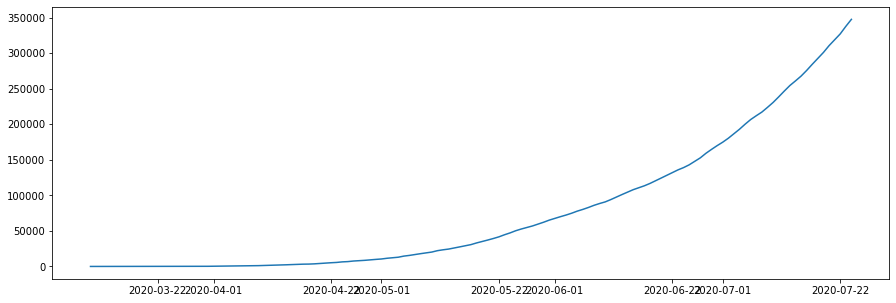

In [217]:
plt.plot(d)

In [218]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [219]:
d.head()

,Confirmed
Date,
2020-03-10,5
2020-03-12,11
2020-03-13,14
2020-03-15,32
2020-03-17,39


In [220]:
d.shape

(131, 1)

In [221]:
dates = [i.to_pydatetime().date() for i in d.index]
base_date = dates[0]
days=[int((i-base_date).days) for i in dates]

In [222]:
d['Days passed'] = days

In [223]:
d.index = days

In [224]:
d

,Confirmed,Days passed
0,5,0
2,11,2
3,14,3
5,32,5
7,39,7
...,...,...
132,310455,132
133,318695,133
134,327031,134
135,337607,135


In [225]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

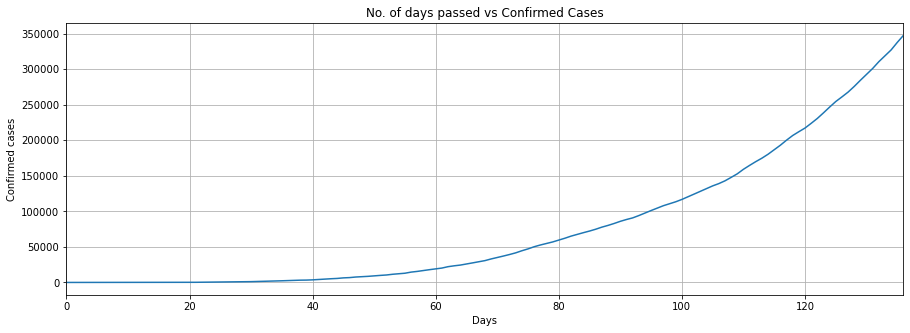

In [226]:
plt.title('No. of days passed vs Confirmed Cases')
plt.ylabel('Confirmed cases')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(d['Confirmed'])

In [227]:
all_data = d['Confirmed'].values.astype(float)

In [228]:
print(all_data)

[5.00000e+00 1.10000e+01 1.40000e+01 3.20000e+01 3.90000e+01 4.20000e+01
 4.70000e+01 5.20000e+01 6.30000e+01 6.70000e+01 7.40000e+01 8.90000e+01
 1.28000e+02 1.30000e+02 1.80000e+02 1.86000e+02 1.98000e+02 2.16000e+02
 3.02000e+02 3.35000e+02 4.90000e+02 7.48000e+02 8.68000e+02 1.01800e+03
 1.13500e+03 1.36400e+03 1.57400e+03 1.76100e+03 1.98500e+03 2.33700e+03
 2.68700e+03 2.91900e+03 3.20500e+03 3.32300e+03 3.65100e+03 4.20300e+03
 4.66900e+03 5.22100e+03 5.65200e+03 6.43000e+03 6.81700e+03 7.62800e+03
 8.06800e+03 8.59000e+03 9.31800e+03 9.91500e+03 1.04980e+04 1.15060e+04
 1.22960e+04 1.29740e+04 1.45410e+04 1.55250e+04 1.67580e+04 1.79740e+04
 1.90630e+04 2.02280e+04 2.21710e+04 2.34010e+04 2.44270e+04 2.59220e+04
 2.75240e+04 2.91000e+04 3.07060e+04 3.30530e+04 3.50580e+04 3.71360e+04
 3.92970e+04 4.16420e+04 4.45820e+04 4.71900e+04 5.02310e+04 5.26670e+04
 5.47580e+04 5.69480e+04 5.95460e+04 6.22280e+04 6.51680e+04 6.76550e+04
 7.00130e+04 7.23000e+04 7.48600e+04 7.77930e+04 8.

In [229]:
test_data_size = 20

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [230]:
print(len(train_data))
print(len(test_data))

111
20


In [231]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [232]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.        ]
 [-0.99993782]
 [-0.99990673]
 [-0.99972019]
 [-0.99964764]]
[[0.76053061]
 [0.81108376]
 [0.86846646]
 [0.93404669]
 [1.        ]]


In [233]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [234]:
train_window = 10

In [235]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [236]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [237]:
train_inout_seq[:5]

[(tensor([-1.0000, -0.9999, -0.9999, -0.9997, -0.9996, -0.9996, -0.9996, -0.9995,
          -0.9994, -0.9994]),
  tensor([-0.9993])),
 (tensor([-0.9999, -0.9999, -0.9997, -0.9996, -0.9996, -0.9996, -0.9995, -0.9994,
          -0.9994, -0.9993]),
  tensor([-0.9991])),
 (tensor([-0.9999, -0.9997, -0.9996, -0.9996, -0.9996, -0.9995, -0.9994, -0.9994,
          -0.9993, -0.9991]),
  tensor([-0.9987])),
 (tensor([-0.9997, -0.9996, -0.9996, -0.9996, -0.9995, -0.9994, -0.9994, -0.9993,
          -0.9991, -0.9987]),
  tensor([-0.9987])),
 (tensor([-0.9996, -0.9996, -0.9996, -0.9995, -0.9994, -0.9994, -0.9993, -0.9991,
          -0.9987, -0.9987]),
  tensor([-0.9982]))]

In [238]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [239]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [240]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [241]:
epochs = 250

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01623761
epoch:  26 loss: 0.00000030
epoch:  51 loss: 0.00063443
epoch:  76 loss: 0.00040369
epoch: 101 loss: 0.00000111
epoch: 126 loss: 0.00000152
epoch: 151 loss: 0.00000409
epoch: 176 loss: 0.00000067
epoch: 201 loss: 0.00045728
epoch: 226 loss: 0.00000457
epoch: 249 loss: 0.0000007302


In [242]:
fut_pred = 20

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.4808923006057739, 0.5310620069503784, 0.5831282138824463, 0.6491230130195618, 0.7060496807098389, 0.7605305910110474, 0.8110837340354919, 0.8684664368629456, 0.9340466856956482, 1.0]


In [243]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [244]:
test_inputs[fut_pred:]

[2.391930103302002,
 1.9802651405334473,
 1.5555987358093262,
 1.326454758644104,
 1.0489556789398193,
 0.9803180694580078,
 0.7955336570739746,
 0.611041784286499,
 0.6995210647583008,
 0.8057918548583984]

In [245]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
print(actual_predictions)
print(actual_predictions.shape)

[[200766.21648192]
 [210266.40396655]
 [223050.00887424]
 [240096.41430736]
 [263995.64876199]
 [293773.41337442]
 [306605.80166698]
 [303273.23276937]
 [309438.52779031]
 [317264.91949618]
 [327300.81549287]
 [287578.23407292]
 [246601.11101508]
 [224490.43579847]
 [197713.8558501 ]
 [191090.84131718]
 [173260.53140521]
 [155458.44937027]
 [163996.03634119]
 [174250.37055492]]
(20, 1)


In [246]:
x = d.index[-20:]
print(x)
print(x.shape)

Int64Index([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
            130, 131, 132, 133, 134, 135, 136],
           dtype='int64')
(20,)


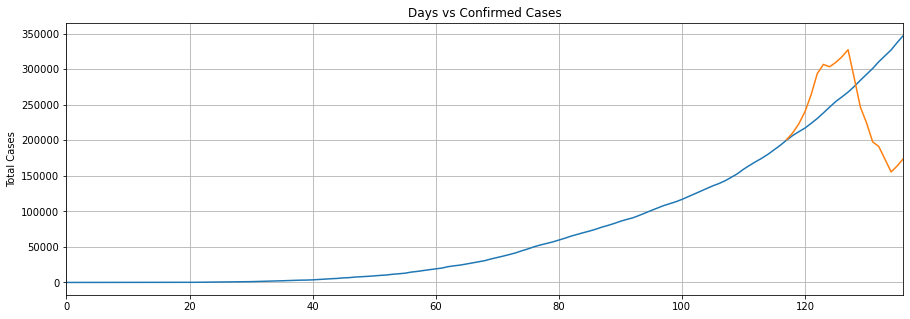

In [247]:
plt.title('Days vs Confirmed Cases')
plt.ylabel('Total Cases')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(d['Confirmed'])
plt.plot(x,actual_predictions)
plt.show()

In [248]:
x

Int64Index([117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
            130, 131, 132, 133, 134, 135, 136],
           dtype='int64')

In [208]:
len(d)

130